WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


0: 288x512 2 persons, 1 car, 62.9ms
Speed: 2.6ms preprocess, 62.9ms inference, 231.3ms postprocess per image at shape (1, 3, 288, 512)

0: 288x512 2 persons, 2 cars, 2.4ms
Speed: 0.9ms preprocess, 2.4ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 512)

0: 288x512 2 persons, 2 cars, 2.3ms
Speed: 0.7ms preprocess, 2.3ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 512)

0: 288x512 1 person, 3 cars, 2.3ms
Speed: 0.6ms preprocess, 2.3ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 512)

0: 288x512 1 person, 3 cars, 2.3ms
Speed: 0.6ms preprocess, 2.3ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 512)

0: 288x512 1 person, 3 cars, 2.2ms
Speed: 1.0ms preprocess, 2.2ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 512)

0: 288x512 2 persons, 4 cars, 1 truck, 2.2ms
Speed: 0.6ms preprocess, 2.2ms inference, 0.5ms postprocess per image at shape (1,

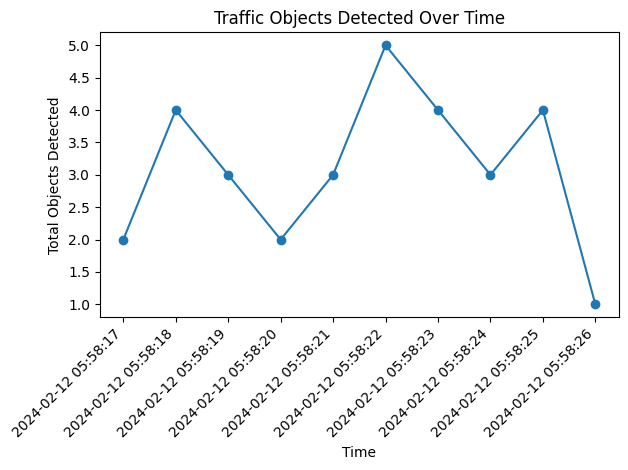

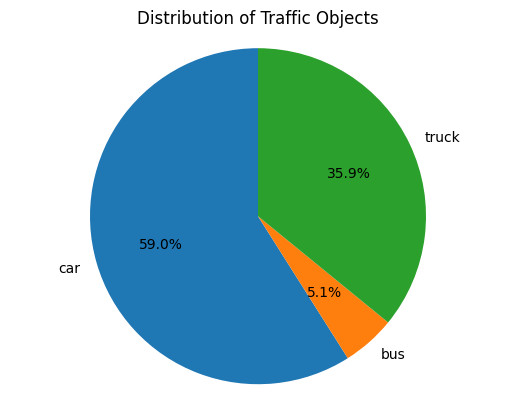

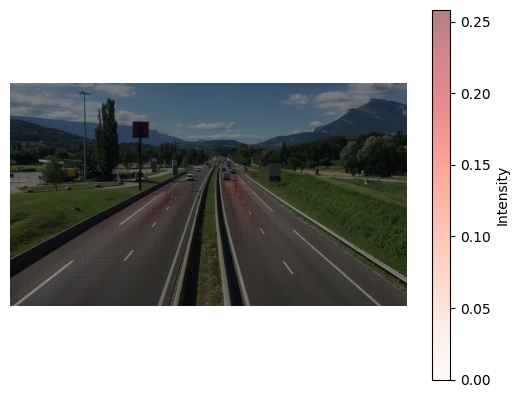

In [1]:
# Creted by: Ahmad Imam (ahmadimam657@gmail.com)



from ultralytics import YOLO
import cv2
import numpy as np
import sqlite3
import ast
from datetime import datetime
import matplotlib.pyplot as plt
from collections import defaultdict
from utils import *



MODEL = "best.pt"
model = YOLO(MODEL)

# Open the video file
video_path = "test_video.mp4"
video_name_track = 'track_result.avi'
cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_name_track = cv2.VideoWriter(video_name_track, 0, 30, (frame_width,frame_height))




heatmap_video_writer = cv2.VideoWriter('heatmap_result.avi', 0, 30, (frame_width,frame_height))
heatmap_obj = heatmap.Heatmap()
heatmap_obj.set_args(colormap=cv2.COLORMAP_PARULA, imw=frame_width, imh=frame_height, shape="circle")



detections = []
count = 0
track_history = defaultdict(lambda: [])
while cap.isOpened():
  success,image = cap.read()
  if success:
    results = model.track(image, persist=True,tracker="bytetrack.yaml")
    heatmap_frame = heatmap_obj.generate_heatmap(image.copy(), results)
    heatmap_video_writer.write(heatmap_frame)
    if results[0].boxes.id != None:
      detections.append({'time': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),'xyxy':list(results[0].boxes.xyxy.cpu().tolist()),
      'confidence':list(results[0].boxes.conf.cpu().tolist()),
      'class_id':list(results[0].boxes.cls.cpu().int().tolist()),
      'object_id':list(map(int,list(results[0].boxes.id.cpu().tolist())))})
      frame = results[0].plot()
      annotated_frame = plot_tracks(frame, results, track_history)
    else:
      annotated_frame = None
    if annotated_frame is not None and annotated_frame.size > 0:
      video_name_track.write(annotated_frame)
    else:
      video_name_track.write(image)
  else:
    break

conn = sqlite3.connect('predictions_database.db')
cursor = conn.cursor()

# Create predictions table if it does not exit
create_predictions_table(cursor)


insert_predictions(cursor, detections)


cursor.execute('SELECT * FROM predictions_bytime')
rows = cursor.fetchall()



count_objects,total_objects,time_objects = get_object_counts(model.names,cursor)


print(f"Total objects detected: {total_objects}")
print(f"type wise count:", {model.names[k]:len(v) for k,v in count_objects.items()})


times = list(time_objects.keys())
counts = list(time_objects.values())

# plot_filtered_counts_over_time(times, counts)
plot_filtered_counts_over_time(times, counts)
plot_non_zero_object_distribution(model.names,count_objects)


dt = [i['xyxy'] for i in detections]
create_heatmap(cv2.imread('frame0.jpg'),dt)